In [2]:
import numpy as np
import matplotlib.pyplot as plt # para plots
import torch as tc
import pandas as pd
import torch.nn as nn

In [3]:

# Função que define a equação diferencial
def EDO_pendulo(t, y):
    theta, d_theta_dt = y
    dd_theta_dt = - (g / L) * np.sin(theta)
    return [d_theta_dt, dd_theta_dt]

def generate_data_set(omega = 1, theta = 0, time_parameters =[] ):
    t_0,t_end,dt = time_parameters    
    # Método de Euler para resolver a EDO
    t_values = np.arange(t_0, t_end, dt)

    theta_values = []
    omega_values = []
    for t in t_values:
        theta_values.append(theta)
        omega_values.append(omega)
        
        # Método de Euler
        dtheta_dt, domega_dt = EDO_pendulo(t, [theta, omega])
        theta += dtheta_dt * dt
        omega += domega_dt * dt

    # Converter o deslocamento angular para coordenadas x-y
    x_values = L * np.sin(theta_values)
    y_values = -L * np.cos(theta_values)
    return [x_values,y_values]

def plot_Pendulum(data):
    x_values, y_values = data 
    # Plotagem
    plt.plot(x_values, y_values)
    plt.xlabel('x (t)')
    plt.ylabel('y (t)')
    plt.title('Movimento do Pêndulo Simples')
    plt.grid(True)
    plt.axis('equal')
    plt.show()      


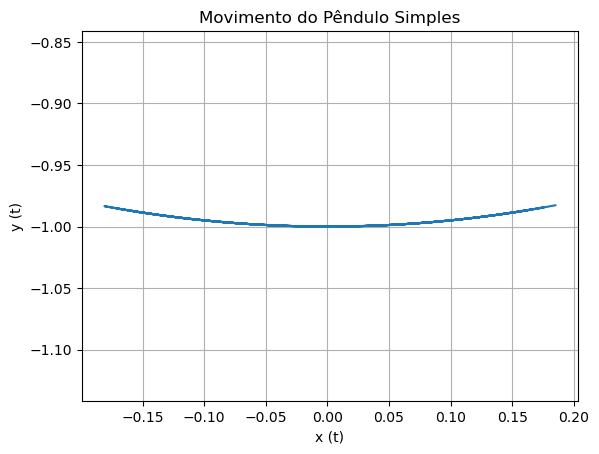

In [4]:
# Constantes
global g, L, phi, omega_0
g = 9.81  # m/s^2, aceleração devido à gravidade
L = 1.0   # m, comprimento do pêndulo
phi = np.pi / 20  # Ângulo inicial em radianos
omega_0 = 0.0        # Velocidade angular inicial

# Parâmetros de tempo
N=1000 # Numero de pontos
t_0 = 0.0            # Tempo inicial
t_end = 6.0         # Tempo final
dt = t_end/N            # Tamanho do passo de tempo
time_parameters = [t_0,t_end,dt]

# Condições iniciais
theta = phi 
omega = omega_0

data = generate_data_set(omega, theta, time_parameters)

plot_Pendulum(data[0:2])


Fazendo dataset de matrizes de imagem

In [5]:
import os
import matplotlib.colors as mcolors
from PIL import Image



def create_colormap():
    colors = ['blue', 'red']
    cmap = mcolors.LinearSegmentedColormap.from_list('blue_to_red', colors)
    return cmap

# Function to save dataset as images
def save_dataset_as_images(data_x, data_y, directory,trailsize = 10):
    # Create directory if it doesn't exist
    os.makedirs(directory, exist_ok=True)
    
    # Determine the number of frames based on the length of one of the data arrays
    num_frames = len(data_x)
    x_min, x_max = -0.2,0.2 #min(data_x), max(data_x)
    y_min, y_max = -1.1, -0.85, #min(data_y), max(data_y)
    # Loop through each frame in the dataset
    for i in range(num_frames):
        # Create a new figure
        plt.figure(figsize=(8, 8))  # Adjust size as needed

        if i>trailsize:
            trail_x = data_x[i-trailsize:i]
            trail_y = data_y[i-trailsize:i]
        else:
            trail_x = data_x[0:i]
            trail_y = data_y[0:i]

        # Plot the points
        plt.scatter(trail_x, trail_y, s=145, c=np.arange(len(trail_x)), cmap=cmap)  # Adjust size as needed

        #plt.scatter(data_x[0:i], data_y[0:i], s=5, c='black')  # Adjust size and color as needed
        
        # Set plot limits if necessary
        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)
        
        # Turn off axis
        plt.axis('off')
        
        # Save the figure as an image
        plt.savefig(os.path.join(directory, f'frame_{i:04d}.png'), bbox_inches='tight', pad_inches=0)
        
        # Close the figure to release memory
        plt.close()


data_x = data[0]  
data_y = data[1]  

# Directory to save images
output_directory = 'pendulum_images'

# Create a colormap from blue to red
cmap = create_colormap()
trailsize=100
# Save dataset as images
save_dataset_as_images(data_x, data_y, output_directory, trailsize)

print(f"Dataset saved as images in '{output_directory}' directory.")


Dataset saved as images in 'pendulum_images' directory.


In [14]:
frames_matrices = []

for i in range(len(data_x)):
    image_path = os.path.join(output_directory, f'frame_{i:04d}.png')
    image = Image.open(image_path)
    matrix = np.array(image)
    rgb_matrix = matrix[:,:,:3] # 376 to set image size 
    # Append the matrix for the current frame to the list
    frames_matrices.append(rgb_matrix)    

frames_matrices = np.array(frames_matrices)
frames_matrices_tensor = tc.tensor(frames_matrices, dtype=tc.float32)



: 

# Construindo uma CNN para analisar o data-set

In [ ]:
def plot_input(img):
    image_np = img[0].numpy().transpose((1, 2, 0))
    
    # Plot each channel separately
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    for i in range(3):
        axs[i].imshow(image_np[:, :, i], cmap='gray')  # Use cmap='gray' for grayscale images
        axs[i].set_title(f'Channel {i}')

    plt.show()

def plot_output(recon_img):
    img2 = recon_img[0].detach().numpy()
    image_np2 = img2.transpose((1, 2, 0))
    # Plot each channel separately
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    for i in range(3):
        axs[i].imshow(image_np2[:, :, i], cmap='gray')  # Use cmap='gray' for grayscale images
        axs[i].set_title(f'Channel {i}')

    plt.show()


In [ ]:
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, frames_matrices):
        self.frames_matrices = frames_matrices

    def __len__(self):
        return len(self.frames_matrices)

    def __getitem__(self, idx):
        image = self.frames_matrices[idx]
        # Assuming image is already normalized between 0 and 1
        image = tc.tensor(image, dtype=tc.float32)
        return image

# Define the autoencoder model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 18, 10, stride=2, padding=1),  # b, 16, 76, 76
            nn.MaxPool2d(kernel_size=10, stride=2),
            nn.ReLU(True),
            nn.Conv2d(18, 14, 4, stride=2, padding=1),  # b, 8, 38, 38
            nn.MaxPool2d(kernel_size=4, stride=2),
            nn.ReLU(True),
            nn.Conv2d(14, 4, 3, stride=2, padding=1),  # b, 8, 38, 38
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(4, 4, 3, stride=2, padding=1),  # b, 8, 38, 38
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(True)
        )
        self.middlelayer = nn.Sequential(
            nn.Flatten(),  # Flatten the feature maps
            nn.Linear( 16, 32),  # Dense layer with 50 neurons
            nn.ReLU(True),
            nn.Linear(32, 20),  # Dense layer with 50 neurons
            nn.ReLU(True),
            nn.Linear(20, 32),  # Dense layer with 50 neurons
            nn.ReLU(True),
            nn.Linear(32, 5),  # Dense layer with 5 neurons
            nn.Tanh(),
        )
        self.rnn = nn.LSTM(5, 20, 10)
        #self.rnn2 = nn.LSTM(25, 5, 13)
        self.middlelayer2 = nn.Sequential(
            nn.Linear(20,32),  # Dense layer with 50 neurons # MIDDLELAYER
            nn.Tanh(),
            #nn.Linear(5,32),  # Dense layer with 50 neurons # MIDDLELAYER
            #nn.Tanh(),
            nn.Linear(32, 20),  # Dense layer with 50 neurons
            nn.ReLU(True),
            nn.Linear(20, 32),  # Dense layer with 50 neurons
            nn.ReLU(True),
            nn.Linear(32,3 * 6 * 6),  # Dense layer with 50 neurons
            nn.Unflatten(1, (3, 6,6))  # Reshape back to feature maps
        )
        self.decoder = nn.Sequential(
            nn.ReLU(True),
            nn.Upsample(scale_factor=3, mode='nearest'),
            nn.ConvTranspose2d(3, 16, 3, stride=2, padding=1, output_padding=1),  # b, 16, 76, 76
            nn.ReLU(True),
            #nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ConvTranspose2d(16, 13, 8, stride=2, padding=1, output_padding=1),  # b, 3, 151, 151
            nn.ReLU(True),
            nn.ConvTranspose2d(13, 13, 4, stride=2, padding=1, output_padding=1),  # b, 3, 151, 151
            nn.ReLU(True),
            nn.ConvTranspose2d(13, 11, 3, stride=2, padding=1, output_padding=1),  # b, 3, 151, 151
            nn.ReLU(True),
            nn.ConvTranspose2d(11, 3, 2, stride=2, padding=1, output_padding=1),  # b, 3, 151, 151
            #nn.ReLU(True),
            #nn.ConvTranspose2d(3, 3, 2, stride=2, padding=1, output_padding=1),
            #nn.ReLU(True)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.middlelayer(x)
        x = x.unsqueeze(0)
        x, _ = self.rnn(x)
        #x, _ = self.rnn2(x)
        x = x.squeeze(0)
        x = self.middlelayer2(x)
        x = self.decoder(x)
        return x


In [1]:
# Hyperparameters
batch_size = 32
learning_rate = 1e-1
num_epochs = 200

# Example: frames_matrices = np.random.rand(10000, 387, 385, 3)

# Create DataLoader
dataset = CustomDataset(frames_matrices)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Initialize the autoencoder model and loss function
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

LOSS = []
# Training loop
for epoch in range(num_epochs):
    for data in dataloader:
        img = data.permute(0, 3, 1, 2)  # Change the order of dimensions for Conv2d input
        recon_img = model(img)
        loss = criterion(recon_img, img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        LOSS.append(loss.cpu().detach().numpy())

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    if ((epoch)%5) ==0:    
        plt.plot(np.log(LOSS))
        plt.yscale('log')
        plt.ylabel("Loss")
        plt.xlabel("Epochs")
        plt.show()    
        plot_input(img)
        plot_output(recon_img)

# Save the trained model
tc.save(model.state_dict(), 'autoencoder.pth')


NameError: name 'CustomDataset' is not defined